# Unsupervised Dimensionality Reduction

If your number of features is high, it may be useful to reduce it with an unsupervised step prior to supervised steps.

### Dimensionality Reduction methods:

* **Decomposing signals in components**
    * PCA
    * TruncatedSVD
    * Kernel PCA (Gaussian & Polynomial kernel)
    * Non-negative matrix factorization (NMF)
    * Latent Dirichlet Allocation (LDA)  
    * Factor Analysis
* **Random projections**
    * Gaussian random projection
    * Sparse random projection
* **Feature agglomeration**
    * AgglomerativeClustering

## Import Python Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload

## Import Utility Classes

In [2]:
%autoreload 2
import sys
sys.path.append('..')

from utils.data_loader import DataLoader
from utils.term_counter_helper import TermFrequency, TfIdf
from utils.data_frame_helper import DataFrameHelper
from utils.dimensionality_reducer_helper import DimensionalityReducer

## Load Data

In [3]:
loader = DataLoader()
content = loader.load_data("../Data/trainingdata.txt")

Number of Rows:  5485



In [4]:
label_names = np.array(["A", "B", "C", "D", "E", "F", "G", "H"])
df = loader.get_data_frame(content, label_names)
df_helper = DataFrameHelper(df, label_names)

5485 documents
8 categories


## Input Dataset in DataFrame Format

In [5]:
df_helper.df.head()

,Labels,Text
0,A,champion products ch approves stock split cham...
1,B,computer terminal systems cpml completes sale ...
2,A,cobanco inc cbco year net shr cts vs dlrs net ...
3,A,am international inc am nd qtr jan oper shr lo...
4,A,brown forman inc bfd th qtr net shr one dlr vs...


## Vectorization of Text Data with TF-IDF Featurization

In [6]:
min_df = 2

tfidf = TfIdf(
    label_names,
    norm='l2',
    smooth_idf = True,
    sublinear_tf = False,
    lowercase=True,
    preprocessor=None,
    tokenizer=None,
    stop_words='english',
    ngram_range=(1, 1),
    analyzer='word',
    max_df=0.8, # 0.5, 0.75, 1.0
    min_df = min_df,
    max_features=None,
    vocabulary=None)

tfidf.vectorize_corpus(df_helper.raw_text)

Feature Matrix:
n_samples: 5485 
n_features: 10416


## t-distributed Stochastic Neighbor Embedding (t-SNE)

High-dimensional datasets can be very difficult to visualize. While data in two or three dimensions can be plotted to show the inherent structure of the data, equivalent high-dimensional plots are much less intuitive. To aid visualization of the structure of a dataset, the dimension must be reduced in some way.

**t-SNE** converts affinities of data points to probabilities. The affinities in the original space are represented by Gaussian joint probabilities and the affinities in the embedded space are represented by Student’s t-distributions. This allows t-SNE to be particularly sensitive to local structure and has a few other advantages over existing techniques:
Revealing the structure at many scales on a single map
Revealing data that lie in multiple, different, manifolds or clusters
Reducing the tendency to crowd points together at the center

While Isomap, LLE and variants are best suited to unfold a single continuous low dimensional manifold, t-SNE will focus on the local structure of the data and will tend to extract clustered local groups of samples. This ability to group samples based on the local structure might be beneficial to visually disentangle a dataset that comprises several manifolds at once.

The Kullback-Leibler (KL) divergence of the joint probabilities in the original space and the embedded space will be minimized by gradient descent. Note that the KL divergence is not convex, i.e. multiple restarts with different initializations will end up in local minima of the KL divergence. Hence, it is sometimes useful to try different seeds and select the embedding with the lowest KL divergence.

## t-SNE Projection of Raw High Dimensional Data

In [7]:
reducer = DimensionalityReducer(tfidf.X)

In [9]:
reducer.plot_TSNE_projection(reducer.X, df_helper.y)

## Principal component analysis (PCA)

PCA is used to decompose a multivariate dataset in a set of successive orthogonal components that explain a maximum amount of the variance.

The PCA object also provides a probabilistic interpretation of the PCA that can give a likelihood of data based on the amount of variance it explains.

## PCA: Dimensionality Reduction of Feature Matrix

In [8]:
X_pca = reducer.fit_reducer("PCA", n_components=100)

Explained variance of the SVD step: 36%


## t-SNE Projection

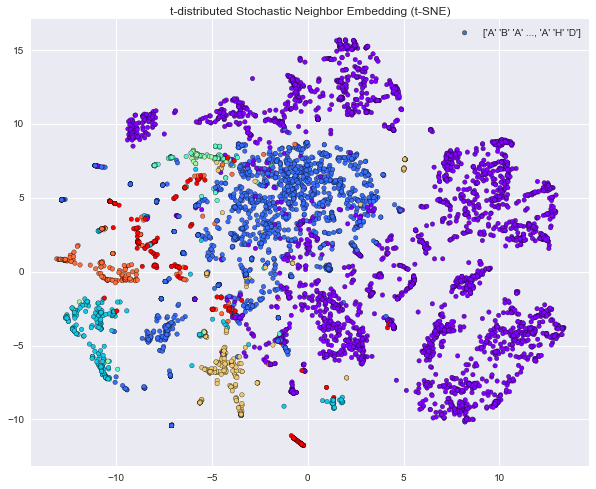

In [20]:
reducer.plot_TSNE_projection(X_pca, df_helper.y)

##  Model selection with Probabilistic PCA and Factor Analysis 
**Explore Log-likelihood of Data for Different Dimensionality**

Probabilistic PCA and Factor Analysis are probabilistic models. The consequence is that the likelihood of new data can be used for model selection and covariance estimation. Here we compare PCA and FA with cross-validation

best n_components by PCA CV = 1000
best n_components by FactorAnalysis CV = 10


/Users/marvin/anaconda2/envs/Notebook-env/lib/python3.5/site-packages/sklearn/preprocessing/data.py:167: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


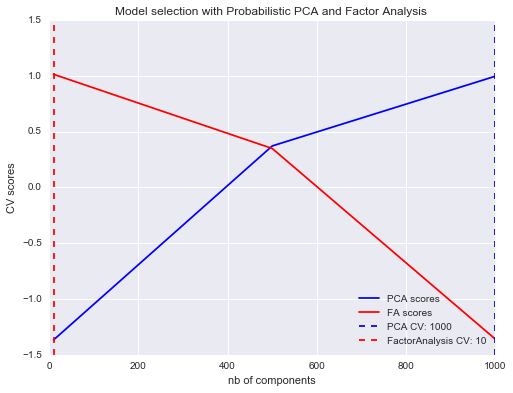

In [43]:
n_components = np.asarray([10, 500, 1000])

plot_model_selection(n_components)

## TruncatedSVD

**TruncatedSVD** implements a variant of singular value decomposition (SVD) that only computes the k largest singular values, where k is a user-specified parameter.

When truncated SVD is applied to term-document matrices (as returned by CountVectorizer or TfidfVectorizer), this transformation is known as latent semantic analysis (LSA), because it transforms such matrices to a “semantic” space of low dimensionality. In particular, LSA is known to combat the effects of synonymy and polysemy (both of which roughly mean there are multiple meanings per word), which cause term-document matrices to be overly sparse and exhibit poor similarity under measures such as cosine similarity.

Mathematically, truncated SVD applied to training samples X produces a low-rank approximation $X$:
$$X \approx X_k = U_k \Sigma_k V_k^\top$$
After this operation, $U_k \Sigma_k^\top$ is the transformed training set with $k$ features (called n_components in the API).
To also transform a test set X, we multiply it with $V_k$:
$$X' = X V_k$$

TruncatedSVD is very similar to PCA, but differs in that it works on sample matrices X directly instead of their covariance matrices. When the columnwise (per-feature) means of $X$ are subtracted from the feature values, truncated SVD on the resulting matrix is equivalent to PCA.

## SVD: Dimensionality Reduction of Feature Matrix

In [11]:
X_SVD = reducer.fit_reducer("TruncatedSVD", n_components=100, n_iter=10)

Explained variance of the signal decomposition step: 36%


## t-SNE Projection

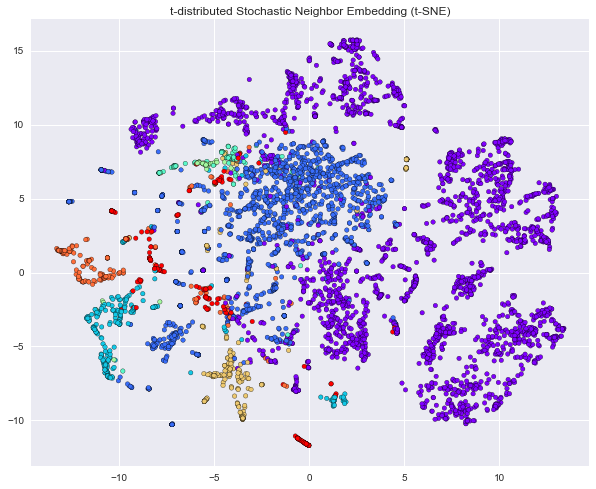

In [12]:
reducer.plot_TSNE_projection(X_SVD, df_helper.y)

## Kernel PCA

**KernelPCA** is an extension of PCA which achieves non-linear dimensionality reduction through the use of kernels. It has many applications including denoising, compression and structured prediction (kernel dependency estimation). 

## Gaussian Kernel: Dimensionality Reduction of Feature Matrix

In [13]:
X_kPCA = reducer.fit_reducer("KernelPCA", n_components=100, kernel='rbf')

## t-SNE Projection

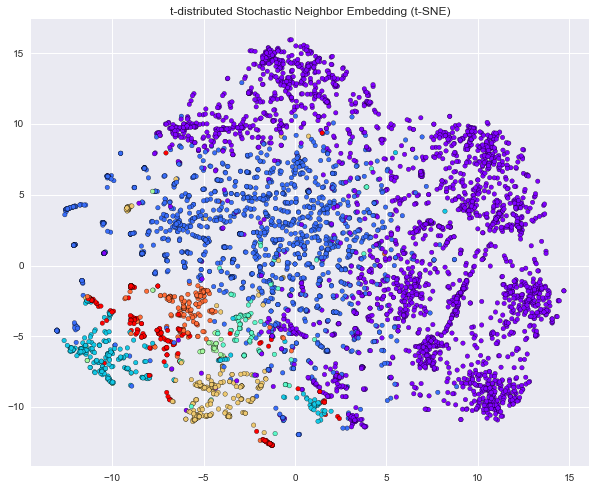

In [14]:
reducer.plot_TSNE_projection(X_kPCA, df_helper.y)

## Gamma 10

In [ ]:
X_kPCA = reducer.fit_reducer("KernelPCA", n_components=100, kernel='rbf', gamma = 10)
reducer.plot_TSNE_projection(X_kPCA, df_helper.y)

## Polynomial Kernel

/Users/marvin/anaconda2/envs/Notebook-env/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


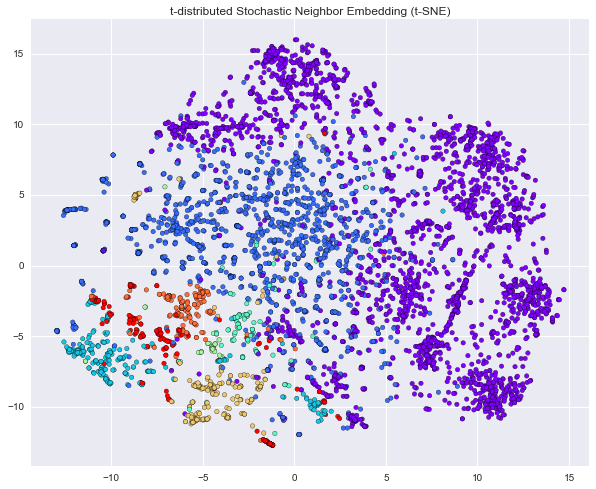

In [22]:
X_kPCA = reducer.fit_reducer("KernelPCA", n_components=100, kernel='poly')
reducer.plot_TSNE_projection(X_kPCA, df_helper.y)

## Non-negative matrix factorization (NMF )

**NMF** is an alternative approach to decomposition that assumes that the data and the components are non-negative. NMF can be plugged in instead of PCA or its variants, in the cases where the data matrix does not contain negative values. It finds a decomposition of samples X into two matrices W and H of non-negative elements, by optimizing for the squared Frobenius norm:
$$\arg\min_{W,H} \frac{1}{2} ||X - WH||_{Fro}^2 = \frac{1}{2} \sum_{i,j} (X_{ij} - {WH}_{ij})^2$$

This norm is an obvious extension of the Euclidean norm to matrices. (Other optimization objectives have been suggested in the NMF literature, in particular Kullback-Leibler divergence, but these are not currently implemented.)
Unlike PCA, the representation of a vector is obtained in an additive fashion, by superimposing the components, without subtracting. Such additive models are efficient for representing images and text.

In [ ]:
X_NMF = reducer.fit_reducer("NMF", n_components=100, alpha=.1, l1_ratio=.5)
reducer.plot_TSNE_projection(X_NMF, df_helper.y)

##  Latent Dirichlet Allocation (LDA)

Latent Dirichlet Allocation is a generative probabilistic model for collections of discrete dataset such as text corpora. It is also a topic model that is used for discovering abstract topics from a collection of documents.
The graphical model of LDA is a three-level Bayesian model:

When LatentDirichletAllocation is applied on a “document-term” matrix, the matrix will be decomposed into a “topic-term” matrix and a “document-topic” matrix.

In [ ]:
X_LDA = reducer.fit_reducer("LDA", n_components=100)
reducer.plot_TSNE_projection(X_LDA, df_helper.y)